In [1]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoConfig

roberta_tokenizer = AutoTokenizer.from_pretrained("WillHeld/roberta-base-sst2")
roberta_model = AutoModelForSequenceClassification.from_pretrained("WillHeld/roberta-base-sst2", output_hidden_states=True)

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/994 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [2]:
import csv

def read_csv_file(file_path):
    data = []
    with open(file_path, 'r') as file:
        csv_reader = csv.reader(file)
        for row in csv_reader:
            data.append(row)
    return data

file_path = "/kaggle/input/probing-dataset/textfooler-dataset.csv"
data = read_csv_file(file_path)

In [3]:
import numpy as np

roberta_embedding_representation = [[] for _ in range(13)]
for input in data:
    input_embed = roberta_tokenizer(input[0], return_tensors="pt")
    output = roberta_model(**input_embed)
    hidden_states = output.hidden_states
    for i, state in enumerate(hidden_states):
        state = state.detach().cpu().numpy().squeeze()
        avg_state = np.mean(state, axis=0)
        roberta_embedding_representation[i].append(avg_state)

In [4]:
target = np.array([int(input[1]) for input in data])

In [5]:
from sklearn.linear_model import LogisticRegression

class ProbingClassifier:
    def __init__(self):
        self.classifier = LogisticRegression(max_iter=1000)
    
    def fit(self, X, y):
        self.classifier.fit(X, y)
    
    def predict(self, X):
        return self.classifier.predict(X)

    def score(self, X, y):
        return self.classifier.score(X, y)

In [6]:
from sklearn.model_selection import train_test_split
roberta_probing_classifier = ProbingClassifier()
roberta_classifier_scores = []
for i, embedding in enumerate(roberta_embedding_representation):
    X = roberta_embedding_representation[i]
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
    roberta_probing_classifier.fit(X_train, y_train)
    acc = roberta_probing_classifier.score(X_test, y_test)
    print(f"Layer {i} score: {acc}")
    roberta_classifier_scores.append(acc)

Layer 0 score: 0.49444444444444446
Layer 1 score: 0.5277777777777778
Layer 2 score: 0.5666666666666667
Layer 3 score: 0.6
Layer 4 score: 0.6055555555555555
Layer 5 score: 0.65
Layer 6 score: 0.7055555555555556
Layer 7 score: 0.6888888888888889
Layer 8 score: 0.7111111111111111
Layer 9 score: 0.7388888888888889
Layer 10 score: 0.8111111111111111
Layer 11 score: 0.7888888888888889
Layer 12 score: 0.8111111111111111


In [7]:
from transformers import CanineModel
import torch

model2 = CanineModel.from_pretrained("google/canine-c", output_hidden_states=True)  # model pre-trained with autoregressive character loss

config.json:   0%|          | 0.00/698 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/529M [00:00<?, ?B/s]

In [8]:
canine_embedding_representation = [[] for _ in range(13)]
for input in data:
    input_ids = torch.tensor([[ord(char) for char in input[0]]])
    outputs = model2(input_ids)
    hidden_states = output.hidden_states
    for i, state in enumerate(hidden_states):
        state = state.detach().cpu().numpy().squeeze()
        avg_state = np.mean(state, axis=0)
        canine_embedding_representation[i].append(avg_state)

In [9]:
canine_probing_classifier = ProbingClassifier()
canine_classifier_scores = []
for i, embedding in enumerate(canine_embedding_representation):
    X = canine_embedding_representation[i]
    X_train, X_test, y_train, y_test = train_test_split(X, target, test_size=0.2, random_state=42)
    canine_probing_classifier.fit(X_train, y_train)
    acc = canine_probing_classifier.score(X_test, y_test)
    print(f"Deep Layer {i} score: {acc}")
    canine_classifier_scores.append(acc)

Deep Layer 0 score: 0.45
Deep Layer 1 score: 0.45
Deep Layer 2 score: 0.45
Deep Layer 3 score: 0.45
Deep Layer 4 score: 0.45
Deep Layer 5 score: 0.45
Deep Layer 6 score: 0.45
Deep Layer 7 score: 0.45
Deep Layer 8 score: 0.45
Deep Layer 9 score: 0.45
Deep Layer 10 score: 0.45
Deep Layer 11 score: 0.45
Deep Layer 12 score: 0.45


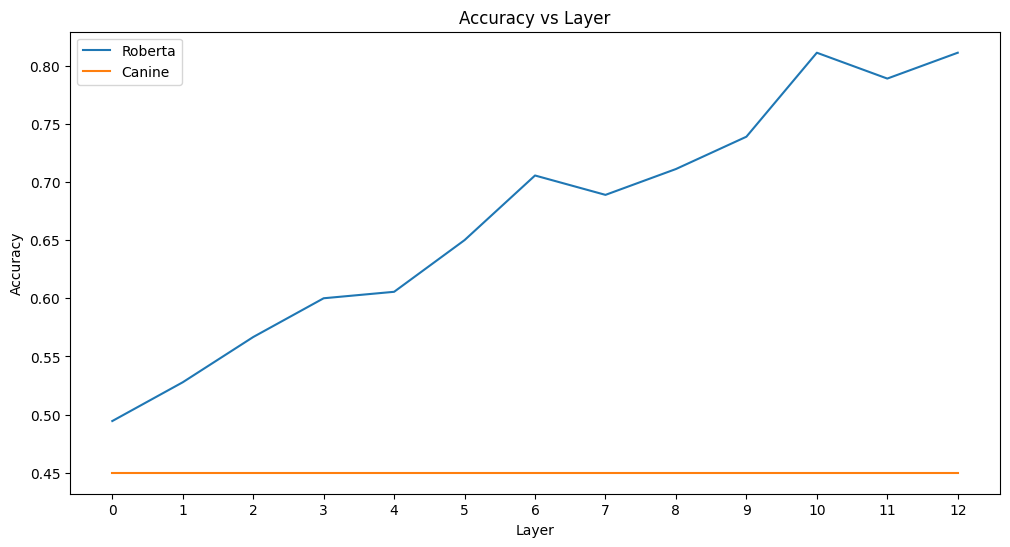

In [10]:
import matplotlib.pyplot as plt

layers = range(0, len(roberta_classifier_scores))
plt.figure(figsize=(12, 6))  # Adjust the width and height as per your preference
plt.plot(layers, roberta_classifier_scores, label='Roberta')
plt.plot(layers, canine_classifier_scores, label='Canine')
plt.xlabel('Layer')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Layer')
# Mark integers on the x-axis
plt.xticks(layers)
plt.legend()
plt.show()

In [37]:
normal = []
adv = []
for i, representation in enumerate(roberta_embedding_representation[12]):
    if(target[i] == 0):
        normal.append(representation)
    else:
        adv.append(representation)

In [38]:
normal_stack = np.stack(normal)
adv_stack = np.stack(adv)

In [39]:
mean_normal = np.mean(normal_stack, axis=0)
mean_adv = np.mean(adv_stack, axis=0)
steering_vector = mean_adv - mean_normal

In [40]:
X = roberta_embedding_representation[12]
classifier = ProbingClassifier()
classifier.fit(X, target)


In [41]:
def apply_steering_vector_and_get_result(input):
    input_embed = roberta_tokenizer(input, return_tensors="pt")
    output = roberta_model(**input_embed)
    hidden_states = output.hidden_states
    representation = hidden_states[12].detach().cpu().numpy().squeeze()
    representation = np.mean(representation, axis=0)
    new_representation = representation + steering_vector
    representation = representation.reshape(1, -1)
    print("Input: ", input)
    print("Original classification: ")
    print(classifier.predict(representation)[0])
    new_representation = new_representation.reshape(1, -1)
    print("Steered classification: ")
    print(classifier.predict(new_representation)[0])
    print()

In [42]:
apply_steering_vector_and_get_result("This is a bright and nice morning . ")
apply_steering_vector_and_get_result("it 's a charming and often affecting journey .")

Input:  This is a bright and nice morning . 
Original classification: 
0
Steered classification: 
1

Input:  it 's a charming and often affecting journey .
Original classification: 
0
Steered classification: 
1

